На это семинаре будет необходимо (1) реализовать Dropout-слой и проследить его влияние на обобщающую способность сети (2) реализовать BatchNormalization-слой и пронаблюдать его влияние на скорость сходимости обучения.

## Dropout (0.6 балла)

Как всегда будем экспериментировать на датасете MNIST. MNIST является стандартным бенчмарк-датасетом, и его можно подгрузить средствами pytorch.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
input_size = 784
num_classes = 10
batch_size = 128

train_dataset = dsets.MNIST(root='./MNIST/', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Определим ряд стандартных функций с прошлых семинаров

In [0]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log, acc_log    

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        data = Variable(x_batch)
        target = Variable(y_batch)

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy') 
        print("MIN VAL LOSS: {} \nMAX VAL ACC: {}".format
              (round(np.min(np.array(val_log)[:,1]),5), round(np.max(np.array(val_acc_log)[:,1]),5)))

Создайте простейшую однослойную модель - однослойную полносвязную сеть и обучите ее с параметрами оптимизации, заданными ниже.

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(dim=-1)
    )

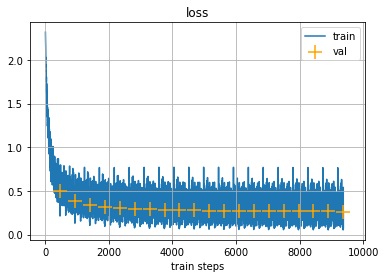

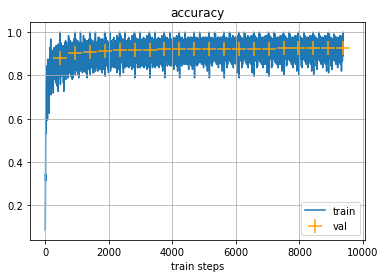

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 20)

Параметром обученной нейросети является матрица весов, в которой каждому классу соответствует один из 784-мерных столбцов. Визуализируйте обученные векторы для каждого из классов, сделав их двумерными изображениями 28-28. Для визуализации можно воспользоваться кодом для визуализации MNIST-картинок с предыдущих семинаров.

In [0]:
import seaborn as sns

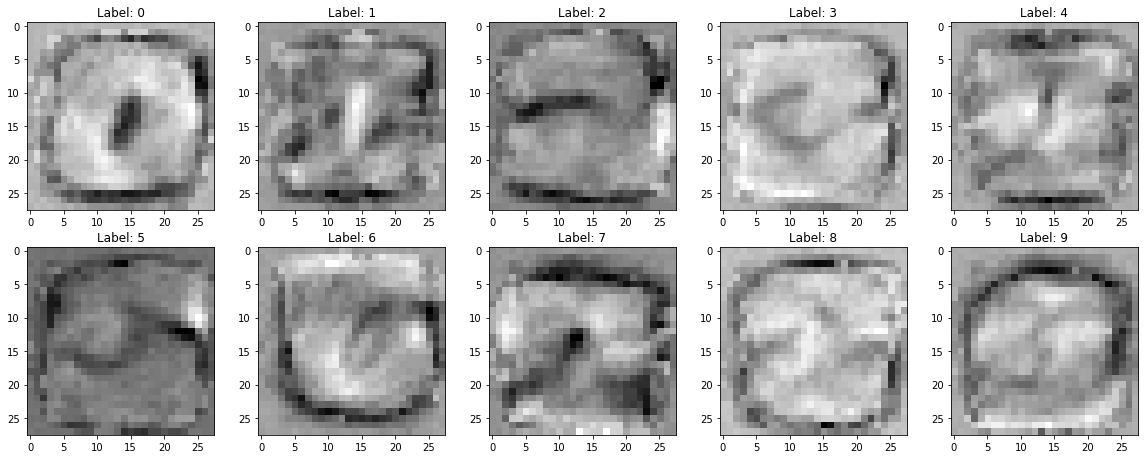

In [0]:
#<start your code>
weights = model[1].weight.data.numpy()
#<end your code>
plt.figure(figsize=[20, 20])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

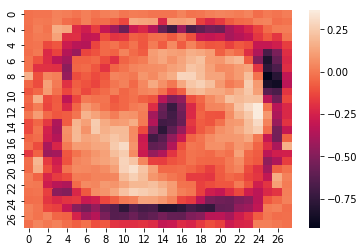

In [0]:
sns.heatmap(weights[0].reshape([28,28]))

Реализуйте Dropout-слой для полносвязной сети. Помните, что этот слой ведет себя по-разному во время обучения и во время применения. 

In [0]:
class DropoutLayer(nn.Module):
    def __init__(self, p):
        super().__init__()
        #<your code>
        self.p = p
        self.mask = torch.Tensor()
        
        #torch.Tensor.bernoulli_(p)

    def forward(self, input):
        if self.training:
            self.mask.resize_as_(input.data)
            self.mask.bernoulli_(1.0 - self.p)
            var = Variable(self.mask, requires_grad=False)
            return input * var / (1.0 - self.p)
            #<your code>
            
        else:
            #<your code>
            return input

Добавьте Dropout-слой в архитектуру сети, проведите оптимизацию с параметрами, заданными ранее, визуализируйте обученные веса. Есть ли разница между весами, обученными с Dropout и без него? Параметр Dropout возьмите равным 0.7

In [0]:
modelDp = nn.Sequential(
    Flatten(),
    DropoutLayer(0.7), # гиперпараметр - на валидейт
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(dim=-1)
    )

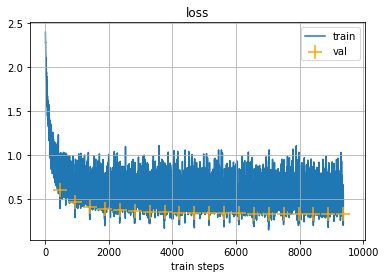

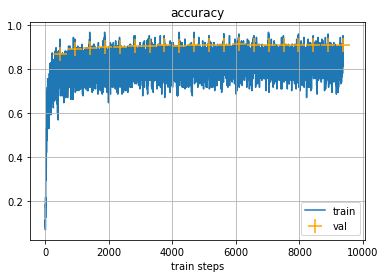

MIN VAL LOSS: 0.33123 
MAX VAL ACC: 0.91307


In [0]:
opt = torch.optim.Adam(modelDp.parameters(), lr=0.0005)
train(modelDp, opt, 20)
#accuracy на val может быть лучше, так как мы зануляем жестко на трейне, но когда ей дают нормальные данные (тест), она делает хороший accuracy

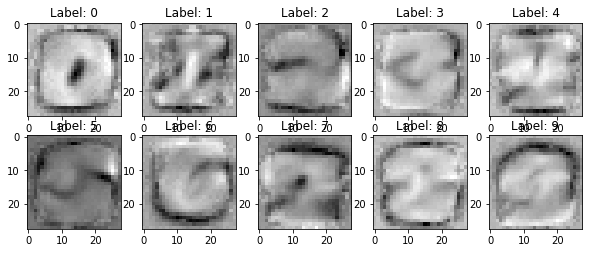

In [0]:
#weights = #<your code>
weights = modelDp[2].weight.data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Обучите еще одну модель, в которой вместо Dropout-регуляризации используется L2-регуляризация с коэффициентом 0.05. (Параметр weight_decay в оптимизаторе). Визуализируйте веса и сравните с двумя предыдущими подходами.

In [0]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size,num_classes),
    nn.LogSoftmax(dim=-1)
    )

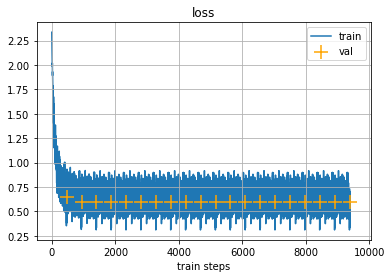

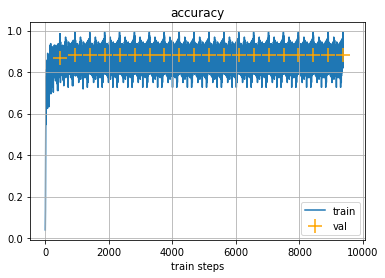

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.05) # добавили регуляризацию, теперь на веса линейного слоя
train(model, opt, 20)

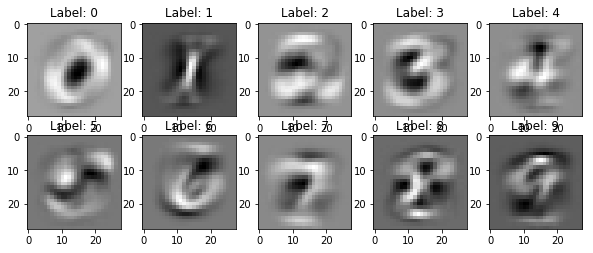

In [0]:
#weights = #<your code>
weights = model[1].weight.data.numpy()

weights = model[1].weight.data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

## Batch normalization (0.4 балла)

Реализуйте BatchNormalization слой для полносвязной сети. В реализации достаточно только центрировать и разделить на корень из дисперсии, аффинную поправку (гамма и бета) в этом задании можно не реализовывать.

In [0]:
class BnLayer(nn.Module):
    def __init__(self, num_features, alpha=1e-1, eps=1e-5):
        super().__init__()
        #<your code>
        self.moving_avg = torch.zeros(num_features)
        self.moving_var = torch.zeros(num_features)
        #self.register_buffer('running_avg', torch.zeros(num_features))
        #self.register_buffer('moving_var', torch.zeros(num_features))
        self.alpha = alpha
        self.eps = eps
        
        #<your code>

    def forward(self, input):
        mu = input.mean(dim=0)
        #[bs  .....]
        #[1 .....]
        #не бьются размерности, keepdim - делает broadcating копирует 
        var = input.std(dim=0)
        if self.training:
            ret = (input - mu) / (var + self.eps)
            self.moving_avg = mu.data * self.alpha + (1 - self.alpha) * self.moving_avg
            self.moving_var = var.data * self.alpha + (1 - self.alpha) * self.moving_var
            #<your code>
        else:
            #<your code>
            x = input - Variable(self.moving_avg, requires_grad=False)
            y = Variable(self.moving_var, requires_grad=False)+self.eps
            ret = x / y
        return ret

Обучите трехслойную полносвязную сеть (размер скрытого слоя возьмите 100) с сигмоидами в качестве функций активации. 

In [0]:
model = nn.Sequential(
    #<your code>
    Flatten(),
    nn.Linear(input_size, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, num_classes),
    nn.LogSoftmax(dim=-1)
    )

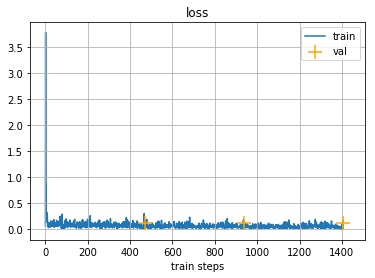

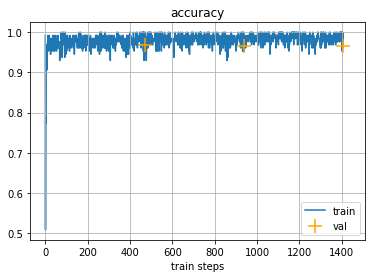

MIN VAL LOSS: 0.10931 
MAX VAL ACC: 0.96826


In [0]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)
train(model, opt, 3)

Повторите обучение с теми же параметрами для сети с той же архитектурой, но с добавлением BatchNorm слоя (для всех трех скрытых слоев).

In [0]:
modelBN = nn.Sequential(
    #<your code>
    Flatten(),
    nn.Linear(input_size, 100),
    BnLayer(100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    BnLayer(100),
    nn.Sigmoid(),
    nn.Linear(100, num_classes),
    nn.LogSoftmax(dim=-1)
    
    )

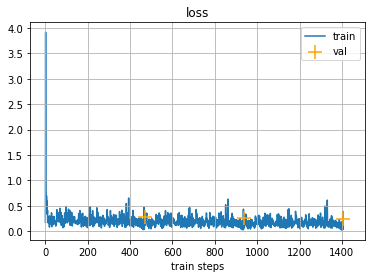

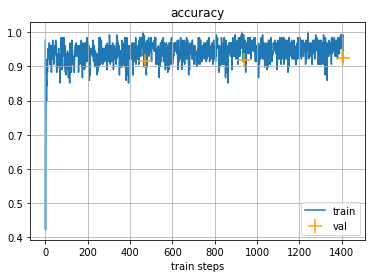

MIN VAL LOSS: 0.25004 
MAX VAL ACC: 0.92544


In [0]:
opt = torch.optim.RMSprop(modelBN.parameters(), lr=0.01)
train(modelBN, opt, 3)

In [0]:
modelBN_relu = nn.Sequential(
    #<your code>
    Flatten(),
    nn.Linear(input_size, 100),
    BnLayer(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    BnLayer(100),
    nn.ReLU(),
    nn.Linear(100, num_classes),
    nn.LogSoftmax(dim=-1)
    )

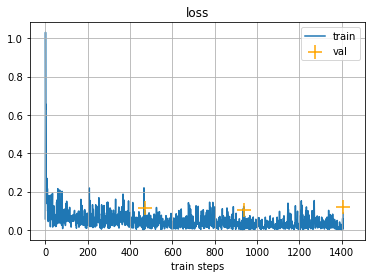

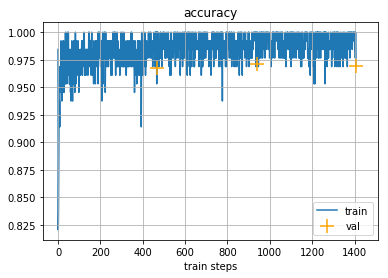

MIN VAL LOSS: 0.10157 
MAX VAL ACC: 0.97073


In [0]:
opt = torch.optim.RMSprop(modelBN_relu.parameters(), lr=0.01)
train(modelBN_relu, opt, 3)

Сравните кривые обучения и сделайте вывод о влиянии BatchNorm на ход обучения.

По итогу получается, что BatchNorm лучше работает для функции активации ReLU, нежели чем для Сигмоидальной